<h3>Simple XGBoost</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count',
            'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
            'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
            'ldl_filename', 'ldl_getArg', 'subDirLen', 'this.fileExtLen', 'ArgLen',
            'pathurlRatio', 'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio',
            'pathDomainRatio', 'argPathRatio', 'executable', 'isPortEighty',
            'NumberofDotsinURL', 'ISIpAddressInDomainName', 'CharacterContinuityRate',
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
            'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
            'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
            'Directory_LetterCount', 'Filename_LetterCount', 'Extension_LetterCount',
            'Query_LetterCount', 'LongestPathTokenLength', 'Domain_LongestWordLength',
            'Path_LongestWordLength', 'sub-Directory_LongestWordLength',
            'Arguments_LongestWordLength', 'URL_sensitiveWord', 'URLQueries_variable',
            'spcharUrl', 'delimeter_Domain', 'delimeter_path', 'delimeter_Count',
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName',
            'NumberRate_FileName', 'NumberRate_Extension', 'NumberRate_AfterPath',
            'SymbolCount_URL', 'SymbolCount_Domain', 'SymbolCount_Directoryname',
            'SymbolCount_FileName', 'SymbolCount_Extension', 'SymbolCount_Afterpath',
            'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension',
            'Entropy_Afterpath']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()

# Convert 'tld' and 'url_type' to string since they're categorical
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

# Select only numeric features for checking infinite values
numeric_features = [f for f in features if f not in ['tld', 'url_type']]

# Apply np.isfinite only to numeric features and filter rows
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Label encoding for TLD and url_type (since they're categorical)
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()

df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Combine all features (numeric + 'tld_encoded') for the model
X = df_cleaned[numeric_features + ['tld_encoded']]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label']
)

# Initialize the XGBoost classifier for binary classification
xgb_binary_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data for binary classification
xgb_binary_classifier.fit(X_train_bin, y_train_bin)

# Make predictions on the training and test data for binary classification
y_train_pred_bin = xgb_binary_classifier.predict(X_train_bin)
y_test_pred_bin = xgb_binary_classifier.predict(X_test_bin)

# Evaluate the model on the training data for binary classification
print("Binary Classification Report (Benign vs Malicious) - Training Data:")
print(classification_report(y_train_bin, y_train_pred_bin))
print("Binary Classification Accuracy (Training):", accuracy_score(y_train_bin, y_train_pred_bin))

# Evaluate the model on the test data for binary classification
print("\nBinary Classification Report (Benign vs Malicious) - Test Data:")
print(classification_report(y_test_bin, y_test_pred_bin))
print("Binary Classification Accuracy (Test):", accuracy_score(y_test_bin, y_test_pred_bin))

# Multiclass Classification for types of malicious URLs
# Only consider the non-benign entries
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Use the 'url_type_encoded' column for the target
X_multi = malicious_df[numeric_features + ['tld_encoded']]
y_multi = malicious_df['url_type_encoded']

# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

# Adjust the multiclass labels so that they start from 0
y_train_multi = y_train_multi - 1
y_test_multi = y_test_multi - 1

# Initialize the XGBoost classifier for multiclass classification
xgb_multiclass_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model on the training data for multiclass classification
xgb_multiclass_classifier.fit(X_train_multi, y_train_multi)

# Make predictions on the training and test data for multiclass classification
y_train_pred_multi = xgb_multiclass_classifier.predict(X_train_multi)
y_test_pred_multi = xgb_multiclass_classifier.predict(X_test_multi)

# Evaluate the model on the training data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Training Data:")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Accuracy (Training):", accuracy_score(y_train_multi, y_train_pred_multi))

# Evaluate the model on the test data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Test Data:")
print(classification_report(y_test_multi, y_test_pred_multi))
print("Multiclass Classification Accuracy (Test):", accuracy_score(y_test_multi, y_test_pred_multi))

# Summary of overall results
print("\nOverall Results Summary:")
print(f"Binary Classification - Training Accuracy: {accuracy_score(y_train_bin, y_train_pred_bin):.4f}")
print(f"Binary Classification - Test Accuracy: {accuracy_score(y_test_bin, y_test_pred_bin):.4f}")
print(f"Multiclass Classification - Training Accuracy: {accuracy_score(y_train_multi, y_train_pred_multi):.4f}")
print(f"Multiclass Classification - Test Accuracy: {accuracy_score(y_test_multi, y_test_pred_multi):.4f}")

# Show encoded url_type
print("\nEncoded URL Types:")
print(malicious_df[['url_type', 'url_type_encoded']].drop_duplicates().reset_index(drop=True))


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Binary Classification Report (Benign vs Malicious) - Training Data:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    299672
           1       0.98      0.95      0.96    156161

    accuracy                           0.97    455833
   macro avg       0.98      0.97      0.97    455833
weighted avg       0.98      0.97      0.97    455833

Binary Classification Accuracy (Training): 0.9749820658004138

Binary Classification Report (Benign vs Malicious) - Test Data:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    128431
           1       0.97      0.95      0.96     66927

    accuracy                           0.97    195358
   macro avg       0.97      0.97      0.97    195358
weighted avg       0.97      0.97      0.97    195358

Binary Classification Accuracy (Test): 0.9728600825151773


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Multiclass Classification Report (Malicious Type) - Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67520
           1       1.00      0.97      0.98     22764
           2       0.99      0.99      0.99     65877

    accuracy                           0.99    156161
   macro avg       0.99      0.98      0.99    156161
weighted avg       0.99      0.99      0.99    156161

Multiclass Classification Accuracy (Training): 0.9901960156505145

Multiclass Classification Report (Malicious Type) - Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28937
           1       0.99      0.96      0.98      9756
           2       0.98      0.98      0.98     28234

    accuracy                           0.99     66927
   macro avg       0.99      0.98      0.98     66927
weighted avg       0.99      0.99      0.99     66927

Multiclass Classification Accuracy (Test

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['CharacterContinuityRate', 'subDirLen', 'avgpathtokenlen',
    'NumberofDotsinURL', 'Entropy_URL', 'sub-Directory_LongestWordLength',
    'ldl_url', 'Entropy_Filename', 'Filename_LetterCount', 'ldl_filename',
    'delimeter_Count', 'charcompvowels', 'LongestPathTokenLength',
    'spcharUrl', 'NumberRate_URL', 'delimeter_path',
    'SymbolCount_Directoryname', 'NumberRate_FileName', 'Entropy_Domain']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()

# Select only numeric features for checking infinite values
numeric_features = [f for f in features]

# Apply np.isfinite only to numeric features and filter rows
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]


# Combine all features (numeric + 'tld_encoded') for the model
X = df_cleaned[numeric_features]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label']
)

# Initialize the XGBoost classifier for binary classification
xgb_binary_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data for binary classification
xgb_binary_classifier.fit(X_train_bin, y_train_bin)

# Make predictions on the training and test data for binary classification
y_train_pred_bin = xgb_binary_classifier.predict(X_train_bin)
y_test_pred_bin = xgb_binary_classifier.predict(X_test_bin)

# Evaluate the model on the training data for binary classification
print("Binary Classification Report (Benign vs Malicious) - Training Data:")
print(classification_report(y_train_bin, y_train_pred_bin))
print("Binary Classification Accuracy (Training):", accuracy_score(y_train_bin, y_train_pred_bin))

# Evaluate the model on the test data for binary classification
print("\nBinary Classification Report (Benign vs Malicious) - Test Data:")
print(classification_report(y_test_bin, y_test_pred_bin))
print("Binary Classification Accuracy (Test):", accuracy_score(y_test_bin, y_test_pred_bin))

# Multiclass Classification for types of malicious URLs
# After creating 'binary_label', apply LabelEncoder to the entire df_cleaned
label_encoder_url_type = LabelEncoder()
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Adjust the labels to start from 0 (subtract 1 if they start from 1)
df_cleaned['url_type_encoded'] = df_cleaned['url_type_encoded'] - df_cleaned['url_type_encoded'].min()

# Now create malicious_df and ensure it contains 'url_type_encoded'
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Use the 'url_type_encoded' column for the target
X_multi = malicious_df[numeric_features]
y_multi = malicious_df['url_type_encoded']

# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

# Initialize the XGBoost classifier for multiclass classification
xgb_multiclass_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model on the training data for multiclass classification
xgb_multiclass_classifier.fit(X_train_multi, y_train_multi)

# Make predictions on the training and test data for multiclass classification
y_train_pred_multi = xgb_multiclass_classifier.predict(X_train_multi)
y_test_pred_multi = xgb_multiclass_classifier.predict(X_test_multi)

# Evaluate the model on the training data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Training Data:")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Accuracy (Training):", accuracy_score(y_train_multi, y_train_pred_multi))

# Evaluate the model on the test data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Test Data:")
print(classification_report(y_test_multi, y_test_pred_multi))
print("Multiclass Classification Accuracy (Test):", accuracy_score(y_test_multi, y_test_pred_multi))

# Summary of overall results
print("\nOverall Results Summary:")
print(f"Binary Classification - Training Accuracy: {accuracy_score(y_train_bin, y_train_pred_bin):.4f}")
print(f"Binary Classification - Test Accuracy: {accuracy_score(y_test_bin, y_test_pred_bin):.4f}")
print(f"Multiclass Classification - Training Accuracy: {accuracy_score(y_train_multi, y_train_pred_multi):.4f}")
print(f"Multiclass Classification - Test Accuracy: {accuracy_score(y_test_multi, y_test_pred_multi):.4f}")

# Show encoded url_type
print("\nEncoded URL Types:")
print(malicious_df[['url_type', 'url_type_encoded']].drop_duplicates().reset_index(drop=True))



c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Binary Classification Report (Benign vs Malicious) - Training Data:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    299672
           1       0.97      0.95      0.96    156161

    accuracy                           0.97    455833
   macro avg       0.97      0.97      0.97    455833
weighted avg       0.97      0.97      0.97    455833

Binary Classification Accuracy (Training): 0.9731129602288557

Binary Classification Report (Benign vs Malicious) - Test Data:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    128431
           1       0.97      0.94      0.96     66927

    accuracy                           0.97    195358
   macro avg       0.97      0.96      0.97    195358
weighted avg       0.97      0.97      0.97    195358

Binary Classification Accuracy (Test): 0.9708023218910923


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [1 2 3]

<h3>XGBoost, Hyperparameter : GridSearchCV</h3>

Binary Classification Report (Benign vs Malicious) - Training Data:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    299672
           1       0.98      0.95      0.96    156161

    accuracy                           0.98    455833
   macro avg       0.98      0.97      0.97    455833
weighted avg       0.98      0.98      0.98    455833

Binary Classification Accuracy (Training): 0.9751509873133363

Binary Classification Report (Benign vs Malicious) - Test Data:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    128431
           1       0.98      0.94      0.96     66927

    accuracy                           0.97    195358
   macro avg       0.97      0.97      0.97    195358
weighted avg       0.97      0.97      0.97    195358

Binary Classification Accuracy (Test): 0.9729522210505841

Feature Importance for Binary Classification (Benign vs Malicious):


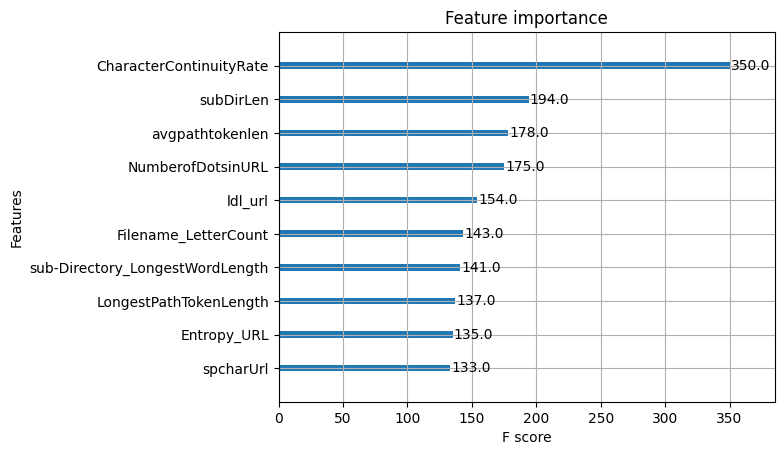

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters from Grid Search: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

Multiclass Classification Report (Malicious Type) - Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67520
           1       1.00      0.98      0.99     22764
           2       0.99      1.00      0.99     65877

    accuracy                           1.00    156161
   macro avg       1.00      0.99      0.99    156161
weighted avg       1.00      1.00      1.00    156161

Multiclass Classification Accuracy (Training): 0.9956519233355319

Multiclass Classification Report (Malicious Type) - Test Data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     28937
           1       0.99      0.96      0.98      9756
           2       0.99      0.99      0.99     28234

    accuracy                 

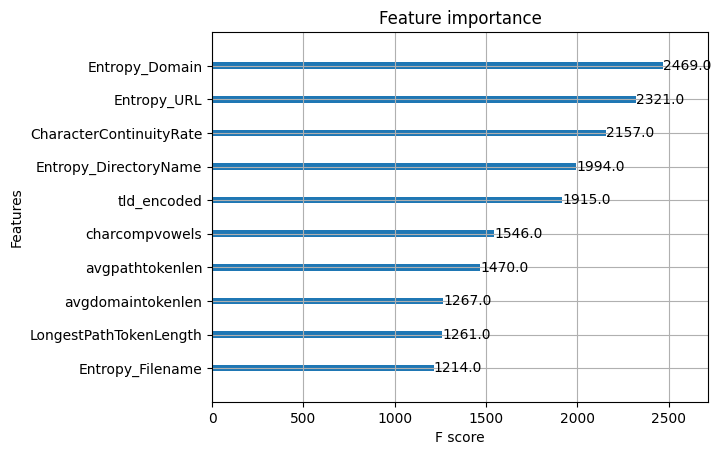


Overall Results Summary:
Binary Classification - Training Accuracy: 0.9752
Binary Classification - Test Accuracy: 0.9730
Multiclass Classification - Training Accuracy: 0.9957
Multiclass Classification - Test Accuracy: 0.9877

Encoded URL Types:
     url_type  url_type_encoded
0    phishing                 2
1  defacement                 0
2     malware                 1


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = [a]

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()
df_cleaned['tld'] = df_cleaned['tld'].astype(str)  # Convert 'tld' to string
numeric_features = [f for f in features if f != 'tld']
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Label encoding for TLD (since it's categorical)
df_cleaned['tld_encoded'] = LabelEncoder().fit_transform(df_cleaned['tld'])

# Combine all features (without the original 'tld' column)
X = df_cleaned[numeric_features + ['tld_encoded']]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label']
)

# Initialize the XGBoost classifier for binary classification
xgb_binary_classifier = XGBClassifier(eval_metric='logloss', random_state=42)

# Fit the model on the training data for binary classification
xgb_binary_classifier.fit(X_train_bin, y_train_bin)

# Make predictions on the training and test data for binary classification
y_train_pred_bin = xgb_binary_classifier.predict(X_train_bin)
y_test_pred_bin = xgb_binary_classifier.predict(X_test_bin)

# Evaluate the model on the training data for binary classification
print("Binary Classification Report (Benign vs Malicious) - Training Data:")
print(classification_report(y_train_bin, y_train_pred_bin))
print("Binary Classification Accuracy (Training):", accuracy_score(y_train_bin, y_train_pred_bin))

# Evaluate the model on the test data for binary classification
print("\nBinary Classification Report (Benign vs Malicious) - Test Data:")
print(classification_report(y_test_bin, y_test_pred_bin))
print("Binary Classification Accuracy (Test):", accuracy_score(y_test_bin, y_test_pred_bin))

# Plot feature importance for binary classification
print("\nFeature Importance for Binary Classification (Benign vs Malicious):")
plot_importance(xgb_binary_classifier, max_num_features=10)
plt.show()

# Multiclass Classification for types of malicious URLs
# Only consider the non-benign entries
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Encode URL types into categories: spam, phishing, malware, defamation
label_encoder = LabelEncoder()
malicious_df['url_type_encoded'] = label_encoder.fit_transform(malicious_df['url_type'])

# Select features and target for multiclass classification
X_multi = malicious_df[numeric_features + ['tld_encoded']]
y_multi = malicious_df['url_type_encoded']

# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

# Initialize the XGBoost classifier for multiclass classification
xgb_multiclass_classifier = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_multiclass_classifier,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1)

# Fit the model using Grid Search
grid_search.fit(X_train_multi, y_train_multi)

# Best parameters from Grid Search
print("Best Parameters from Grid Search:", grid_search.best_params_)

# Make predictions on the training and test data for multiclass classification using the best model
y_train_pred_multi = grid_search.predict(X_train_multi)
y_test_pred_multi = grid_search.predict(X_test_multi)

# Evaluate the model on the training data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Training Data:")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Accuracy (Training):", accuracy_score(y_train_multi, y_train_pred_multi))

# Evaluate the model on the test data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Test Data:")
print(classification_report(y_test_multi, y_test_pred_multi))
print("Multiclass Classification Accuracy (Test):", accuracy_score(y_test_multi, y_test_pred_multi))

# Plot feature importance for multiclass classification
print("\nFeature Importance for Multiclass Classification (Malicious Type):")
plot_importance(grid_search.best_estimator_, max_num_features=10)
plt.show()

# Summary of overall results
print("\nOverall Results Summary:")
print(f"Binary Classification - Training Accuracy: {accuracy_score(y_train_bin, y_train_pred_bin):.4f}")
print(f"Binary Classification - Test Accuracy: {accuracy_score(y_test_bin, y_test_pred_bin):.4f}")
print(f"Multiclass Classification - Training Accuracy: {accuracy_score(y_train_multi, y_train_pred_multi):.4f}")
print(f"Multiclass Classification - Test Accuracy: {accuracy_score(y_test_multi, y_test_pred_multi):.4f}")

# Show encoded url_type
print("\nEncoded URL Types:")
print(malicious_df[['url_type', 'url_type_encoded']].drop_duplicates().reset_index(drop=True))


<h3>XGBoost, SMOTE, Hyperparameter</h3>

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE  # For handling class imbalance

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['path_token_count', 'avgpathtokenlen', 'SymbolCount_URL', 'SymbolCount_FileName', 'tld', 'urlLen']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()

# Convert non-numeric columns ('tld') to string, and process numeric features
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
numeric_features = [f for f in features if f != 'tld']
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Label encoding for TLD (since it's categorical)
df_cleaned['tld_encoded'] = LabelEncoder().fit_transform(df_cleaned['tld'])

# Combine all features (without the original 'tld' column)
X = df_cleaned[numeric_features + ['tld_encoded']]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label'])

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_bin_res, y_train_bin_res = smote.fit_resample(X_train_bin, y_train_bin)

# Step 1: Hyperparameter tuning for Binary Classifier: XGBoost
param_grid_bin = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],  # New hyperparameter
    'gamma': [0, 0.1, 0.3]           # New hyperparameter
}

xgb_binary_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search_bin = GridSearchCV(estimator=xgb_binary_classifier, param_grid=param_grid_bin,
                                scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
grid_search_bin.fit(X_train_bin_res, y_train_bin_res)

print("Best Hyperparameters for Binary Classifier:", grid_search_bin.best_params_)

# Evaluate the best model from the grid search
y_train_pred_bin = grid_search_bin.predict(X_train_bin_res)
print("Binary Classification Report (Benign vs Malicious) - Training Data:")
print(classification_report(y_train_bin_res, y_train_pred_bin))
print("Binary Classification Accuracy (Training):", accuracy_score(y_train_bin_res, y_train_pred_bin))

y_test_pred_bin = grid_search_bin.predict(X_test_bin)
print("\nBinary Classification Report (Benign vs Malicious) - Test Data:")
print(classification_report(y_test_bin, y_test_pred_bin))
print("Binary Classification Accuracy (Test):", accuracy_score(y_test_bin, y_test_pred_bin))

# Step 2: Multiclass Classification (Only on Malicious URLs)
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()  # Create an explicit copy
X_malicious = X[df_cleaned['binary_label'] == 1]

# Label encoding for the type of malicious URL
le_malicious_type = LabelEncoder()
malicious_df['malicious_type_encoded'] = le_malicious_type.fit_transform(malicious_df['URL_Type_obf_Type'])

# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_malicious, malicious_df['malicious_type_encoded'], test_size=0.3, random_state=42)

# Step 2: Hyperparameter tuning for Multiclass Classifier: XGBoost
param_grid_multi = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],  # New hyperparameter
    'gamma': [0, 0.1, 0.3]           # New hyperparameter
}

xgb_multiclass_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_search_multi = GridSearchCV(estimator=xgb_multiclass_classifier, param_grid=param_grid_multi,
                                  scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
grid_search_multi.fit(X_train_multi, y_train_multi)

print("Best Hyperparameters for Multiclass Classifier:", grid_search_multi.best_params_)

# Evaluate the best model from the grid search
y_train_pred_multi = grid_search_multi.predict(X_train_multi)
print("\nMulticlass Classification Report (Malicious Type) - Training Data:")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Accuracy (Training):", accuracy_score(y_train_multi, y_train_pred_multi))

y_test_pred_multi = grid_search_multi.predict(X_test_multi)
print("\nMulticlass Classification Report (Malicious Type) - Test Data:")
print(classification_report(y_test_multi, y_test_pred_multi))
print("Multiclass Classification Accuracy (Test):", accuracy_score(y_test_multi, y_test_pred_multi))

# Print overall summary
print("\nOverall Accuracy Summary:")
print(f"Binary Classification - Training Accuracy: {accuracy_score(y_train_bin_res, y_train_pred_bin):.4f}")
print(f"Binary Classification - Test Accuracy: {accuracy_score(y_test_bin, y_test_pred_bin):.4f}")
print(f"Multiclass Classification - Training Accuracy: {accuracy_score(y_train_multi, y_train_pred_multi):.4f}")
print(f"Multiclass Classification - Test Accuracy: {accuracy_score(y_test_multi, y_test_pred_multi):.4f}")


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:17:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for Binary Classifier: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Binary Classification Report (Benign vs Malicious) - Training Data:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91    299672
           1       0.95      0.85      0.90    299672

    accuracy                           0.90    599344
   macro avg       0.91      0.90      0.90    599344
weighted avg       0.91      0.90      0.90    599344

Binary Classification Accuracy (Training): 0.903182479510932

Binary Classification Report (Benign vs Malicious) - Test Data:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    128431
           1       0.90      0.85      0.87     66927

    accuracy                           0.91    195358
   macro avg       0.91      0.90      0.90    195358
weighted avg       0.91  

c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:27:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for Multiclass Classifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Multiclass Classification Report (Malicious Type) - Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156161

    accuracy                           1.00    156161
   macro avg       1.00      1.00      1.00    156161
weighted avg       1.00      1.00      1.00    156161

Multiclass Classification Accuracy (Training): 1.0

Multiclass Classification Report (Malicious Type) - Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66927

    accuracy                           1.00     66927
   macro avg       1.00      1.00      1.00     66927
weighted avg       1.00      1.00      1.00     66927

Multiclass Classification Accuracy (Test): 1.0

Overall Accuracy Summary:
Binary Cla

<h3>XGBoost, SMOTE</h3>

c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Binary Classification Report (Benign vs Malicious) - Training Data (SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    299672
           1       0.98      0.97      0.97    299672

    accuracy                           0.97    599344
   macro avg       0.97      0.97      0.97    599344
weighted avg       0.97      0.97      0.97    599344

Binary Classification Accuracy (Training): 0.9743936704129849

Binary Classification Report (Benign vs Malicious) - Test Data:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    128431
           1       0.96      0.95      0.96     66927

    accuracy                           0.97    195358
   macro avg       0.97      0.97      0.97    195358
weighted avg       0.97      0.97      0.97    195358

Binary Classification Accuracy (Test): 0.9719642911987223


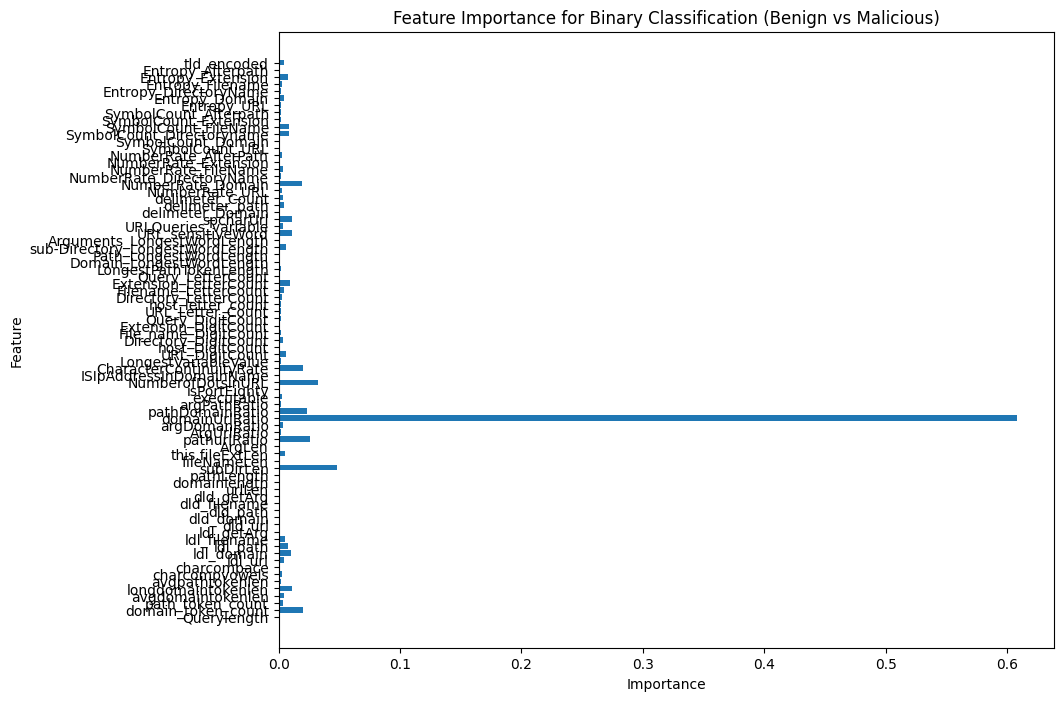

c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Multiclass Classification Report (Malicious Type) - Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67520
           1       1.00      0.97      0.98     22764
           2       0.99      0.99      0.99     65877

    accuracy                           0.99    156161
   macro avg       0.99      0.99      0.99    156161
weighted avg       0.99      0.99      0.99    156161

Multiclass Classification Accuracy (Training): 0.9904649688462548

Multiclass Classification Report (Malicious Type) - Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28937
           1       0.99      0.96      0.98      9756
           2       0.98      0.98      0.98     28234

    accuracy                           0.99     66927
   macro avg       0.99      0.98      0.98     66927
weighted avg       0.99      0.99      0.99     66927

Multiclass Classification Accuracy (Test

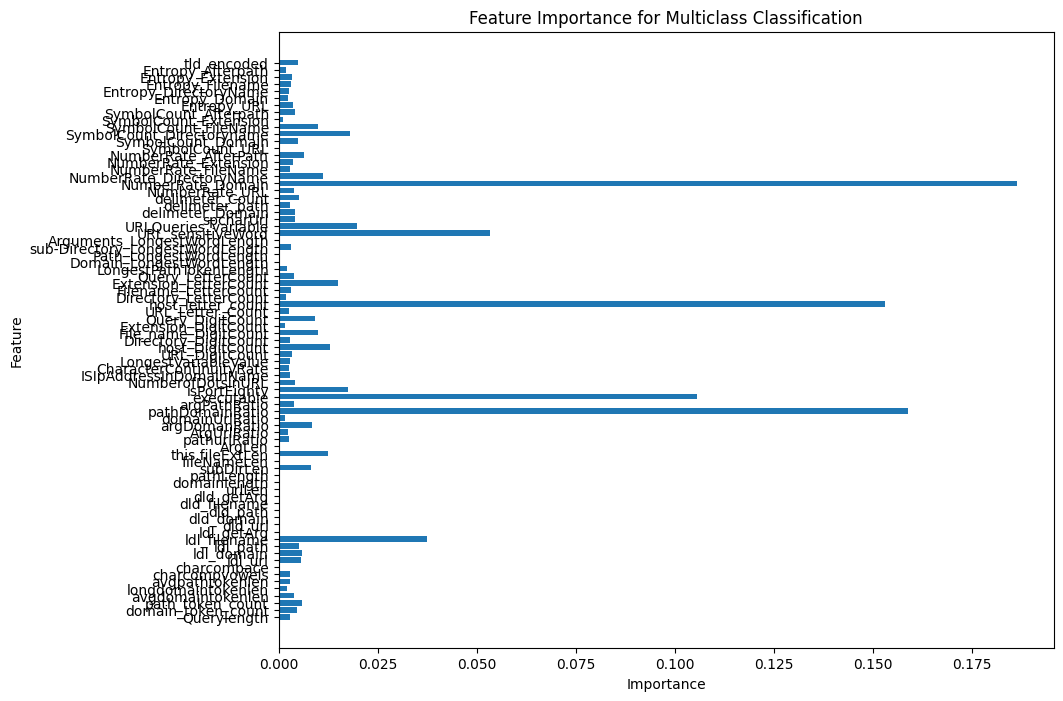


Overall Results Summary:
Binary Classification - Training Accuracy: 0.9744
Binary Classification - Test Accuracy: 0.9720
Multiclass Classification - Training Accuracy: 0.9905
Multiclass Classification - Test Accuracy: 0.9852

Encoded URL Types:
     url_type  url_type_encoded
0    phishing                 2
1  defacement                 0
2     malware                 1


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count',
            'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
            'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
            'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
            'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
            'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
            'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
            'ISIpAddressInDomainName', 'CharacterContinuityRate',
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
            'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
            'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
            'Directory_LetterCount', 'Filename_LetterCount',
            'Extension_LetterCount', 'Query_LetterCount', 'LongestPathTokenLength',
            'Domain_LongestWordLength', 'Path_LongestWordLength',
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength',
            'URL_sensitiveWord', 'URLQueries_variable', 'spcharUrl',
            'delimeter_Domain', 'delimeter_path', 'delimeter_Count',
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName',
            'NumberRate_FileName', 'NumberRate_Extension', 'NumberRate_AfterPath',
            'SymbolCount_URL', 'SymbolCount_Domain', 'SymbolCount_Directoryname',
            'SymbolCount_FileName', 'SymbolCount_Extension',
            'SymbolCount_Afterpath', 'Entropy_URL', 'Entropy_Domain',
            'Entropy_DirectoryName', 'Entropy_Filename', 'Entropy_Extension',
            'Entropy_Afterpath', 'url_type']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()

# Convert 'tld' and 'url_type' to string since they're categorical
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

# Select only numeric features for checking infinite values
numeric_features = [f for f in features if f not in ['tld', 'url_type']]

# Apply np.isfinite only to numeric features and filter rows
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Label encoding for TLD and url_type (since they're categorical)
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()

df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Combine all features (numeric + 'tld_encoded') for the model
X = df_cleaned[numeric_features + ['tld_encoded']]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label']
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_bin_smote, y_train_bin_smote = smote.fit_resample(X_train_bin, y_train_bin)

# Initialize the XGBoost classifier for binary classification
xgb_binary_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the SMOTE-balanced training data for binary classification
xgb_binary_classifier.fit(X_train_bin_smote, y_train_bin_smote)

# Make predictions on the training and test data for binary classification
y_train_pred_bin = xgb_binary_classifier.predict(X_train_bin_smote)
y_test_pred_bin = xgb_binary_classifier.predict(X_test_bin)

# Evaluate the model on the training data for binary classification
print("Binary Classification Report (Benign vs Malicious) - Training Data (SMOTE):")
print(classification_report(y_train_bin_smote, y_train_pred_bin))
print("Binary Classification Accuracy (Training):", accuracy_score(y_train_bin_smote, y_train_pred_bin))

# Evaluate the model on the test data for binary classification
print("\nBinary Classification Report (Benign vs Malicious) - Test Data:")
print(classification_report(y_test_bin, y_test_pred_bin))
print("Binary Classification Accuracy (Test):", accuracy_score(y_test_bin, y_test_pred_bin))

# Feature Importance for Binary Classification
plt.figure(figsize=(10, 8))
feature_importances_bin = xgb_binary_classifier.feature_importances_
plt.barh(X.columns, feature_importances_bin)
plt.title('Feature Importance for Binary Classification (Benign vs Malicious)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Multiclass Classification for types of malicious URLs
# Only consider the non-benign entries
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Encode URL types into categories: spam, phishing, malware, defamation
label_encoder = LabelEncoder()
malicious_df['url_type_encoded'] = label_encoder.fit_transform(malicious_df['url_type'])

# Select features and target for multiclass classification
X_multi = malicious_df[numeric_features + ['tld_encoded']]
y_multi = malicious_df['url_type_encoded']

# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

# Initialize the XGBoost classifier for multiclass classification
xgb_multiclass_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model on the training data for multiclass classification
xgb_multiclass_classifier.fit(X_train_multi, y_train_multi)

# Make predictions on the training and test data for multiclass classification
y_train_pred_multi = xgb_multiclass_classifier.predict(X_train_multi)
y_test_pred_multi = xgb_multiclass_classifier.predict(X_test_multi)

# Evaluate the model on the training data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Training Data:")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Accuracy (Training):", accuracy_score(y_train_multi, y_train_pred_multi))

# Evaluate the model on the test data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Test Data:")
print(classification_report(y_test_multi, y_test_pred_multi))
print("Multiclass Classification Accuracy (Test):", accuracy_score(y_test_multi, y_test_pred_multi))

# Feature Importance for Multiclass Classification
plt.figure(figsize=(10, 8))
feature_importances_multi = xgb_multiclass_classifier.feature_importances_
plt.barh(X_multi.columns, feature_importances_multi)
plt.title('Feature Importance for Multiclass Classification')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Summary of overall results
print("\nOverall Results Summary:")
print(f"Binary Classification - Training Accuracy: {accuracy_score(y_train_bin_smote, y_train_pred_bin):.4f}")
print(f"Binary Classification - Test Accuracy: {accuracy_score(y_test_bin, y_test_pred_bin):.4f}")
print(f"Multiclass Classification - Training Accuracy: {accuracy_score(y_train_multi, y_train_pred_multi):.4f}")
print(f"Multiclass Classification - Test Accuracy: {accuracy_score(y_test_multi, y_test_pred_multi):.4f}")

# Show encoded url_type
print("\nEncoded URL Types:")
print(malicious_df[['url_type', 'url_type_encoded']].drop_duplicates().reset_index(drop=True))


In [5]:
#Machine Learning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

#EXtension
import joblib
import os

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count',
            'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
            'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
            'ldl_filename', 'ldl_getArg', 'dld_domain', 'dld_path',
            'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
            'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
            'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
            'ISIpAddressInDomainName', 'CharacterContinuityRate',
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
            'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
            'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
            'Directory_LetterCount', 'Filename_LetterCount',
            'Extension_LetterCount', 'Query_LetterCount', 'LongestPathTokenLength',
            'Domain_LongestWordLength', 'Path_LongestWordLength',
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength',
            'URL_sensitiveWord', 'URLQueries_variable', 'spcharUrl',
            'delimeter_Domain', 'delimeter_path', 'delimeter_Count',
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName',
            'NumberRate_FileName', 'NumberRate_Extension', 'NumberRate_AfterPath',
            'SymbolCount_URL', 'SymbolCount_Domain', 'SymbolCount_Directoryname',
            'SymbolCount_FileName', 'SymbolCount_Extension',
            'SymbolCount_Afterpath', 'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension',
            'Entropy_Afterpath', 'url_type']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()

# Convert 'tld' and 'url_type' to string since they're categorical
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

# Select only numeric features for checking infinite values
numeric_features = [f for f in features if f not in ['tld', 'url_type']]

# Apply np.isfinite only to numeric features and filter rows
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Label encoding for TLD and url_type (since they're categorical)
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()

df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Combine all features (numeric + 'tld_encoded') for the model
X = df_cleaned[numeric_features + ['tld_encoded']]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label']
)

# Initialize the XGBoost classifier for binary classification
c_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data for binary classification
c_binary.fit(X_train_bin, y_train_bin)


# Multiclass Classification for types of malicious URLs
# Only consider the non-benign entries
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Use the 'url_type_encoded' column for the target
X_multi = malicious_df[numeric_features + ['tld_encoded']]
y_multi = malicious_df['url_type_encoded']

# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

# Adjust the multiclass labels so that they start from 0
y_train_multi = y_train_multi - 1
y_test_multi = y_test_multi - 1

# Initialize the XGBoost classifier for multiclass classification
c_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model on the training data for multiclass classification
c_multi.fit(X_train_multi, y_train_multi)

# Specify the folder path where you want to save the model
folder_path = '../extension/ml'
os.makedirs(folder_path, exist_ok=True)  # This will create the folder if it doesn't exist

# Save the trained model to a file
joblib.dump(c_binary, os.path.join(folder_path,'binary_model.pkl'))
joblib.dump(c_multi, os.path.join(folder_path,'multiclass_model.pkl'))



c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:09:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['../extension/ml\\multiclass_model.pkl']

: 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

#EXtension
import joblib
import os

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count',
            'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
            'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
            'ldl_filename', 'ldl_getArg', 'dld_domain', 'dld_path',
            'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
            'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
            'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
            'ISIpAddressInDomainName', 'CharacterContinuityRate',
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
            'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
            'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
            'Directory_LetterCount', 'Filename_LetterCount',
            'Extension_LetterCount', 'Query_LetterCount', 'LongestPathTokenLength',
            'Domain_LongestWordLength', 'Path_LongestWordLength',
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength',
            'URL_sensitiveWord', 'URLQueries_variable', 'spcharUrl',
            'delimeter_Domain', 'delimeter_path', 'delimeter_Count',
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName',
            'NumberRate_FileName', 'NumberRate_Extension', 'NumberRate_AfterPath',
            'SymbolCount_URL', 'SymbolCount_Domain', 'SymbolCount_Directoryname',
            'SymbolCount_FileName', 'SymbolCount_Extension',
            'SymbolCount_Afterpath', 'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension',
            'Entropy_Afterpath', 'url_type']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()

# Convert 'tld' and 'url_type' to string since they're categorical
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

# Select only numeric features for checking infinite values
numeric_features = [f for f in features if f not in ['tld', 'url_type']]

# Apply np.isfinite only to numeric features and filter rows
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Label encoding for TLD and url_type (since they're categorical)
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()

df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Combine all features (numeric + 'tld_encoded') for the model
X = df_cleaned[numeric_features + ['tld_encoded']]

# Binary classification: Benign vs Malicious
df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Train-Test Split for Binary Classification (Benign vs Malicious)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, df_cleaned['binary_label'], test_size=0.3, random_state=42, stratify=df_cleaned['binary_label']
)

# Initialize the XGBoost classifier for binary classification
xgb_binary_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data for binary classification
xgb_binary_classifier.fit(X_train_bin, y_train_bin)

# Predict probabilities instead of direct class labels
y_train_pred_prob_bin = xgb_binary_classifier.predict_proba(X_train_bin)
y_test_pred_prob_bin = xgb_binary_classifier.predict_proba(X_test_bin)

# Set a custom threshold (e.g., 0.7)
threshold = 0.95

# Convert probabilities to class labels based on the custom threshold
y_train_pred_bin_threshold = (y_train_pred_prob_bin[:, 1] >= threshold).astype(int)
y_test_pred_bin_threshold = (y_test_pred_prob_bin[:, 1] >= threshold).astype(int)

# Evaluate the model with the custom threshold
print("Binary Classification Report (Benign vs Malicious) with Threshold - Training Data:")
print(classification_report(y_train_bin, y_train_pred_bin_threshold))
print("Binary Classification Accuracy with Threshold (Training):", accuracy_score(y_train_bin, y_train_pred_bin_threshold))

print("\nBinary Classification Report (Benign vs Malicious) with Threshold - Test Data:")
print(classification_report(y_test_bin, y_test_pred_bin_threshold))
print("Binary Classification Accuracy with Threshold (Test):", accuracy_score(y_test_bin, y_test_pred_bin_threshold))


# Multiclass Classification for types of malicious URLs
# Only consider the non-benign entries
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Use the 'url_type_encoded' column for the target
X_multi = malicious_df[numeric_features + ['tld_encoded']]
y_multi = malicious_df['url_type_encoded']

# Train-Test Split for Multiclass Classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

# Adjust the multiclass labels so that they start from 0
y_train_multi = y_train_multi - 1
y_test_multi = y_test_multi - 1

# Initialize the XGBoost classifier for multiclass classification
xgb_multiclass_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model on the training data for multiclass classification
xgb_multiclass_classifier.fit(X_train_multi, y_train_multi)

# Make predictions on the training and test data for multiclass classification
y_train_pred_multi = xgb_multiclass_classifier.predict(X_train_multi)
y_test_pred_multi = xgb_multiclass_classifier.predict(X_test_multi)

# Evaluate the model on the training data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Training Data:")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Accuracy (Training):", accuracy_score(y_train_multi, y_train_pred_multi))

# Evaluate the model on the test data for multiclass classification
print("\nMulticlass Classification Report (Malicious Type) - Test Data:")
print(classification_report(y_test_multi, y_test_pred_multi))
print("Multiclass Classification Accuracy (Test):", accuracy_score(y_test_multi, y_test_pred_multi))

# Summary of overall results
print("\nOverall Results Summary:")
print(f"Binary Classification - Training Accuracy: {accuracy_score(y_train_bin, y_train_pred_bin):.4f}")
print(f"Binary Classification - Test Accuracy: {accuracy_score(y_test_bin, y_test_pred_bin):.4f}")
print(f"Multiclass Classification - Training Accuracy: {accuracy_score(y_train_multi, y_train_pred_multi):.4f}")
print(f"Multiclass Classification - Test Accuracy: {accuracy_score(y_test_multi, y_test_pred_multi):.4f}")

# Function to plot feature importance in batches of 20
def plot_feature_importance(importance, features, features_per_plot=20, model_type='binary'):
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features_sorted, scores = zip(*sorted_importance)

    # Plot in batches of 20
    num_features = len(features_sorted)
    for i in range(0, num_features, features_per_plot):
        plt.figure(figsize=(10, 8))
        plt.barh(features_sorted[i:i+features_per_plot], scores[i:i+features_per_plot], color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance ({model_type.capitalize()} Model) - Features {i+1} to {min(i + features_per_plot, num_features)}')
        plt.gca().invert_yaxis()
        plt.show()

# Binary classification feature importance
print("\n--- Feature Importance for Binary Classification Model ---")
binary_importance = xgb_binary_classifier.get_booster().get_score(importance_type='weight')
plot_feature_importance(binary_importance, X.columns, model_type='binary')

# Multiclass classification feature importance
print("\n--- Feature Importance for Multiclass Classification Model ---")
multiclass_importance = xgb_multiclass_classifier.get_booster().get_score(importance_type='weight')
plot_feature_importance(multiclass_importance, X.columns, model_type='multiclass')


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Binary Classification Report (Benign vs Malicious) with Threshold - Training Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    299672
           1       1.00      0.83      0.90    156161

    accuracy                           0.94    455833
   macro avg       0.96      0.91      0.93    455833
weighted avg       0.94      0.94      0.94    455833

Binary Classification Accuracy with Threshold (Training): 0.9399363363337011

Binary Classification Report (Benign vs Malicious) with Threshold - Test Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    128431
           1       1.00      0.83      0.90     66927

    accuracy                           0.94    195358
   macro avg       0.96      0.91      0.93    195358
weighted avg       0.94      0.94      0.94    195358

Binary Classification Accuracy with Threshold (Test): 0.9397465166514809


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Multiclass Classification Report (Malicious Type) - Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67520
           1       1.00      0.97      0.98     22764
           2       0.99      0.99      0.99     65877

    accuracy                           0.99    156161
   macro avg       0.99      0.98      0.99    156161
weighted avg       0.99      0.99      0.99    156161

Multiclass Classification Accuracy (Training): 0.9901960156505145

Multiclass Classification Report (Malicious Type) - Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28937
           1       0.99      0.96      0.98      9756
           2       0.98      0.98      0.98     28234

    accuracy                           0.99     66927
   macro avg       0.99      0.98      0.98     66927
weighted avg       0.99      0.99      0.99     66927

Multiclass Classification Accuracy (Test

NameError: name 'y_train_pred_bin' is not defined